In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# --- Configuration ---

# Set up the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: CUDA (NVIDIA GPU)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print(f"Using device: CPU")

# Desired image size for processing
# Use a larger size if you have a GPU, otherwise, a smaller size is faster
imsize = 512 if torch.cuda.is_available() or torch.backends.mps.is_available() else 128 

print(f"Processing images at size: {imsize}x{imsize}")

Using device: CUDA (NVIDIA GPU)
Processing images at size: 512x512


Style image shape: torch.Size([1, 3, 512, 512])
Content image shape: torch.Size([1, 3, 512, 512])


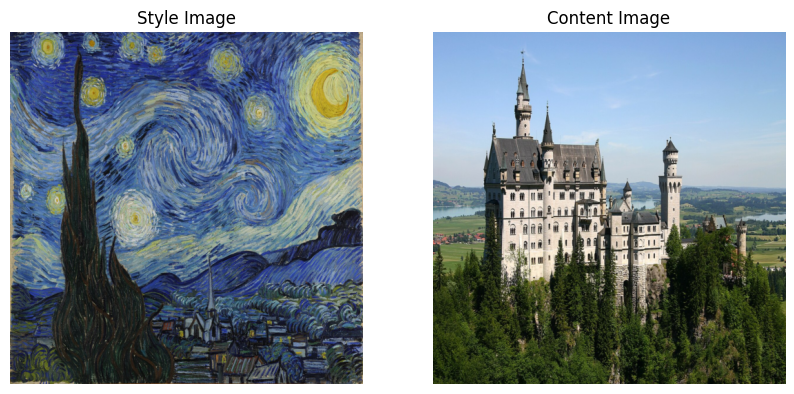

In [2]:
# VGG-19 normalization (mean and std from ImageNet)
# These values are crucial for the pre-trained model to work correctly
vgg_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
vgg_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Create the transformation pipeline
# .to(device) moves the tensor to the GPU (or CPU)
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # Scale imported image
    transforms.ToTensor(),                # Transform to torch tensor (scales to [0, 1])
    # Note: We will apply normalization *inside* our model (in Step 5)
])

def image_loader(image_name):
    try:
        image = Image.open(image_name)
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_name}")
        print("Please double-check the file path.")
        return None
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
        
    # Fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# --- Load Content and Style Images ---

# Paths relative to the 'scripts' folder
content_path = "../images/neuschwanstein.jpg"
style_path = "../images/starry_night.jpg"

style_img = image_loader(style_path)
content_img = image_loader(content_path)

# --- Verification ---

if style_img is not None and content_img is not None:
    print(f"Style image shape: {style_img.shape}")
    print(f"Content image shape: {content_img.shape}")
    
    # Helper function to display an image
    unloader = transforms.ToPILImage() # Convert tensor to PIL Image
    
    def imshow(tensor, title=None):
        image = tensor.cpu().clone()  # Clone tensor to not change it
        image = image.squeeze(0)      # Remove the batch dimension
        image = unloader(image)
        plt.imshow(image)
        if title:
            plt.title(title)
        plt.axis('off')

    # Plot the images to confirm
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    imshow(style_img, title='Style Image')
    
    plt.subplot(1, 2, 2)
    imshow(content_img, title='Content Image')
    
    plt.show()

else:
    print("\nStopping execution due to image loading errors.")
    # This (simple) line will stop a notebook from running further
    assert False, "Please fix image paths before continuing."

In [3]:
# Load the pre-trained VGG-19 model's feature extractor
vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

# Freeze all VGG parameters
for param in vgg19.parameters():
    param.requires_grad_(False)

print("VGG-19 model loaded, moved to device, and all parameters frozen.")

# You can optionally uncomment the line below to see the full list of layers
# (e.g., Conv2d, ReLU, MaxPool2d, etc.)
# print(vgg19)

VGG-19 model loaded, moved to device, and all parameters frozen.


In [4]:
def gram_matrix(input_tensor):
    """
    Calculates the Gram Matrix of a given tensor.
    The tensor is expected to be a batch of feature maps (b, c, h, w).
    """
    b, c, h, w = input_tensor.size()  # b=batch size(=1), c=num feature maps
                                   # (h,w)=dimensions of a feature map
    
    # Reshape the feature map to a 2D matrix: (channels) x (height * width)
    features = input_tensor.view(b * c, h * w) 
    
    # Compute the Gram product (F * F.T)
    # This gives a (channels x channels) matrix of correlations
    G = torch.mm(features, features.t()) 
    
    # Normalize the Gram matrix by dividing by the number of elements
    # in each feature map. This is important to prevent style loss
    # from dominating in larger feature maps.
    return G.div(b * c * h * w)

# --- Content Loss Module ---

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # We 'detach' the target content from the computation graph.
        # This is a fixed value, not a variable we want to optimize.
        # It's our 'goal'.
        self.target = target.detach()
        
    def forward(self, input_tensor):
        # Calculate the Mean Squared Error (MSE) between the
        # input (generated image's features) and the target (content image's features)
        self.loss = F.mse_loss(input_tensor, self.target)
        # We return the input tensor unchanged, so it can
        # flow to the next layer in the model.
        return input_tensor

# --- Style Loss Module ---

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # Calculate the Gram Matrix for the *target style feature*
        # and detach it from the graph. This is our 'goal'.
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input_tensor):
        # Calculate the Gram Matrix for the *input* (generated image's features)
        G = gram_matrix(input_tensor)
        # Calculate the MSE loss between the input's Gram Matrix
        # and the target's Gram Matrix.
        self.loss = F.mse_loss(G, self.target)
        # Return the input tensor unchanged.
        return input_tensor

In [8]:
# --- Define the Normalization Module ---
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# --- THIS IS THE NEW STRATEGY ---
# We are redefining 'style' to only mean low-to-mid level features (textures, colors)
# and removing the high-level features (conv_4, conv_5) which conflict with our content.
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3'] # <-- CHANGED
# --- END OF NEW STRATEGY ---

# Re-define the maps
vgg_layer_map = {
    'conv_1': '0',
    'conv_2': '5',
    'conv_3': '10',
    'conv_4': '19',
    'conv_5': '28'
}
content_layers = [vgg_layer_map[layer] for layer in content_layers_default]
style_layers = [vgg_layer_map[layer] for layer in style_layers_default]


def get_style_model_and_losses(cnn, style_img, content_img,
                               content_layers=content_layers,
                               style_layers=style_layers):
    
    normalization = Normalization(vgg_normalization_mean, vgg_normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)
    i = 0  # layer index

    for layer in cnn.children():
        if isinstance(layer, nn.ReLU):
            layer = nn.ReLU(inplace=False)
        name = str(i)
        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)
        
        i += 1

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            model = model[:(i + 1)]
            break

    return model, style_losses, content_losses

# --- Build the model (Round 8) ---
print("Building the style transfer model (New Strategy: Style = Texture only)...")
model, style_losses, content_losses = get_style_model_and_losses(
    vgg19, style_img, content_img
)

# --- Prepare the Generated Image (Reset) ---
input_img = content_img.clone()
input_img.requires_grad_(True)
model.requires_grad_(False)

print("Model built. Input image (generated) is set up to start from the content image.")

Building the style transfer model (New Strategy: Style = Texture only)...
Model built. Input image (generated) is set up to start from the content image.


In [11]:
# --- Define the Optimizer ---
# We are using our stable, low learning rate
optimizer = optim.Adam([input_img], lr=0.001) 

print("Starting the optimization loop (Round 9 - Final Attempt)...")
print("Using New Layers + Max Style Weight + Stable LR.")

# --- Define Weights and Steps ---
# This is our most aggressive, stable combination
num_steps = 2000
style_weight = 1e10   # 10,000,000,000 (Maximum stable pressure)
content_weight = 1    # 1 (Just to hold the content)

for run in range(num_steps + 1):
    with torch.no_grad():
        input_img.data.clamp_(0, 1)

    optimizer.zero_grad()
    model(input_img)

    style_score = 0
    content_score = 0

    # We are using the style_losses from our new model (conv_1, 2, 3)
    for sl in style_losses:
        style_score += sl.loss
    for cl in content_losses:
        content_score += cl.loss
    
    style_score *= style_weight
    content_score *= content_weight

    total_loss = style_score + content_score
    total_loss.backward()
    optimizer.step()

    if run % 100 == 0:
        print(f"Run {run}/{num_steps}:")
        print(f'  Style Loss: {style_score.item():4f}  '
              f'Content Loss: {content_score.item():4f}  '
              f'Total Loss: {total_loss.item():4f}')
        print("-" * 20)

with torch.no_grad():
    input_img.data.clamp_(0, 1)

print("Optimization Finished.")

Starting the optimization loop (Round 9 - Final Attempt)...
Using New Layers + Max Style Weight + Stable LR.
Run 0/2000:
  Style Loss: 754.750366  Content Loss: 2.133983  Total Loss: 756.884338
--------------------
Run 100/2000:
  Style Loss: 471.400635  Content Loss: 3.183141  Total Loss: 474.583771
--------------------
Run 200/2000:
  Style Loss: 377.896362  Content Loss: 4.163155  Total Loss: 382.059509
--------------------
Run 300/2000:
  Style Loss: 311.480133  Content Loss: 5.039845  Total Loss: 316.519989
--------------------
Run 400/2000:
  Style Loss: 258.512848  Content Loss: 5.795110  Total Loss: 264.307953
--------------------
Run 500/2000:
  Style Loss: 215.130157  Content Loss: 6.436389  Total Loss: 221.566544
--------------------
Run 600/2000:
  Style Loss: 180.469803  Content Loss: 6.950266  Total Loss: 187.420074
--------------------
Run 700/2000:
  Style Loss: 154.381393  Content Loss: 7.337616  Total Loss: 161.719009
--------------------
Run 800/2000:
  Style Loss: 1

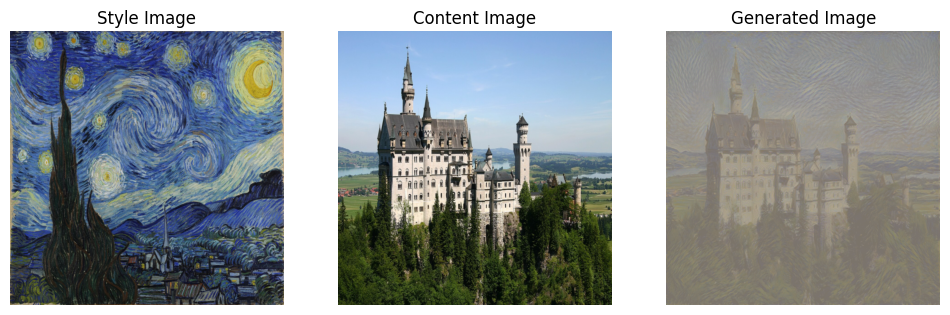

In [12]:
# Create a transformer to convert a tensor back to a PIL image
unloader = transforms.ToPILImage()  # C, H, W -> H, W, C

# --- THIS IS THE FIX ---
# We need CPU versions of the mean and std for de-normalization,
# because the image tensor will be moved to the CPU.
mean_cpu = vgg_normalization_mean.cpu()
std_cpu = vgg_normalization_std.cpu()
# --- END OF FIX ---

def post_process(tensor, title=None):
    """
    Displays a tensor as a PIL image.
    Performs all necessary de-normalization.
    """
    image = tensor.cpu().clone()  # Clone tensor to not change the original
    image = image.squeeze(0)      # Remove the batch dimension
    
    # --- De-normalize the image ---
    # Use the CPU versions of mean and std
    for i in range(3): # For R, G, B channels
        image[i] = image[i] * std_cpu[i] + mean_cpu[i]
        
    # Clamp values to the valid [0, 1] range
    image = image.clamp(0, 1) 
    
    # Convert to a PIL image
    image = unloader(image)
    
    # Display
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')

# --- Display the Final Result ---

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 3)
post_process(input_img, title='Generated Image')

plt.show()

# --- Optional: Save the Final Image ---
# final_image_tensor = input_img.cpu().clone().squeeze(0)
# for i in range(3):
#     final_image_tensor[i] = final_image_tensor[i] * std_cpu[i] + mean_cpu[i]
# final_image_tensor = final_image_tensor.clamp(0, 1)
# final_pil_image = unloader(final_image_tensor)

# You can save it in your images folder
# output_filename = "../images/output_starry_neuschwanstein.jpg"
# final_pil_image.save(output_filename)
# print(f"Saved final image to: {output_filename}")

In [13]:
# --- Step 8: Save the Final Image ---

print("Saving final image...")

# Get the CPU versions of stats (defined in Step 7)
mean_cpu = vgg_normalization_mean.cpu()
std_cpu = vgg_normalization_std.cpu()

# Get the final tensor
final_image_tensor = input_img.cpu().clone().squeeze(0)

# De-normalize
for i in range(3):
    final_image_tensor[i] = final_image_tensor[i] * std_cpu[i] + mean_cpu[i]
    
# Clamp to [0, 1]
final_image_tensor = final_image_tensor.clamp(0, 1)

# Convert to PIL Image
final_pil_image = unloader(final_image_tensor)

# Define save path (relative to 'scripts' folder)
output_filename = "../images/output_image.jpg"

try:
    final_pil_image.save(output_filename)
    print(f"Successfully saved final image to: {output_filename}")
except Exception as e:
    print(f"Error saving image: {e}")

Saving final image...
Successfully saved final image to: ../images/output_image.jpg
